In [1]:
cd ATML-PA-2/CLIP

/kaggle/working/ATML-PA-2/CLIP


# Task 5: Modality Gap in CLIP


### Importing libraries


Importing the necessary libraries for the task.

In [1]:
import os
import torch
import numpy as np
import torchvision
import pathlib
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import tqdm
from torchmetrics import ConfusionMatrix, Precision, Recall, F1Score
from torch import nn

### Initializing Dataset

Specifying the directories in which the Office-Home data is stored.

In [3]:
root_dir = "../datasets/OfficeHomeDataset"
csv_file = f"{root_dir}/ImageInfo.csv"


The office-home dataset is used to evaluate domain adaptation algorithms, and consists of images from 4 different domains: Artistic images, Clip Art, Product images and Real-World images. For each domain, the dataset contains images of 65 object categories found typically in Office and Home settings https://www.hemanthdv.org/officeHomeDataset.html.

In [4]:
from utils.dataset import OfficeHomeDataset

def get_domain_ds(domains, transform=None):
    return OfficeHomeDataset(root_dir, csv_file, domains, transform)

In [5]:
import random
import PIL 

def display(pil_image):
    plt.imshow(pil_image)
    plt.axis("off")     
    plt.tight_layout()
    plt.show()

In [6]:
domains = ["Art", "Real World", "Product","Clipart"]
dataset = get_domain_ds(domains)
classes = dataset.classes
print("Classes: ", classes)

Classes:  ['Alarm_Clock', 'Backpack', 'Batteries', 'Bed', 'Bike', 'Bottle', 'Bucket', 'Calculator', 'Calendar', 'Candles', 'Chair', 'Clipboards', 'Computer', 'Couch', 'Curtains', 'Desk_Lamp', 'Drill', 'Eraser', 'Exit_Sign', 'Fan', 'File_Cabinet', 'Flipflops', 'Flowers', 'Folder', 'Fork', 'Glasses', 'Hammer', 'Helmet', 'Kettle', 'Keyboard', 'Knives', 'Lamp_Shade', 'Laptop', 'Marker', 'Monitor', 'Mop', 'Mouse', 'Mug', 'Notebook', 'Oven', 'Pan', 'Paper_Clip', 'Pen', 'Pencil', 'Postit_Notes', 'Printer', 'Push_Pin', 'Radio', 'Refrigerator', 'Ruler', 'Scissors', 'Screwdriver', 'Shelf', 'Sink', 'Sneakers', 'Soda', 'Speaker', 'Spoon', 'TV', 'Table', 'Telephone', 'ToothBrush', 'Toys', 'Trash_Can', 'Webcam']


Flipflops


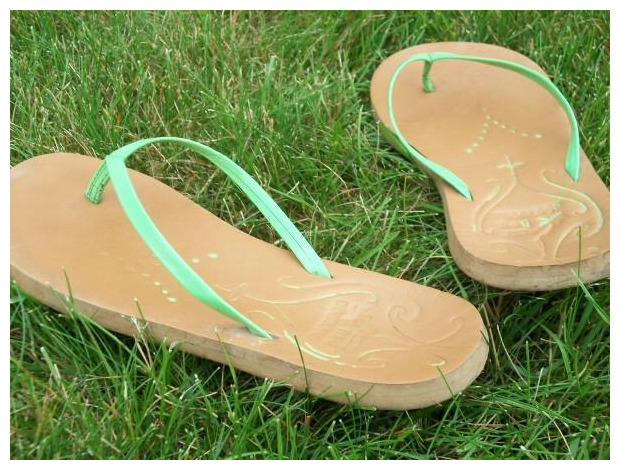

In [7]:
image, label = random.choice(dataset)
print(classes[label])
display(image)

### Downloading and Configuring the CLIP model

Here we import the clip-ViT-B-32 from https://github.com/openai/CLIP and it's corresponding preprocessing transform, 

In [8]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-mjvbd6wi
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-mjvbd6wi
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [36]:
import clip
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, preprocess = clip.load("ViT-B/32", device=device)

### Evaluating Prompting Strategies

Here we test how the zero-shot performance of the model on a few examples and try different prompting strategies. In the first cell, a number of utility functions are defined to help with analysis. 

In [ ]:
from sklearn.metrics import classification_report
import tqdm
from torchmetrics import ConfusionMatrix
import seaborn as sns

# def analyze_sample(text:list[str], seed:int = 100):
#     random.seed(seed)
#     idx = random.randint(0, len(dataset)-1)
#     pil_image, label = dataset[idx]
#     label = dataset.classes[label]

#     image = preprocess(pil_image).unsqueeze(0)
#     text = clip.tokenize(text)

#     with torch.no_grad():
#         logits_per_image, logits_per_text = model(image, text)
#         probs = logits_per_image.softmax(dim=-1).cpu().numpy()
#         prediction = probs.argmax()

#     print("True Label: ", label)
#     print("Label probs: ", classes[prediction])
#     display(pil_image)

def get_image_features(dataset:torch.utils.data.Dataset):
   
    all_features = []
    all_labels = []
    loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=os.cpu_count())
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            features = model.encode_image(images)

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu(), torch.cat(all_labels).cpu()

def get_text_features(text: list[str]):
    with torch.no_grad():
        text = clip.tokenize(text)
        return model.encode_text(text).cpu()


def stats(preds, labels):
    confmat = ConfusionMatrix(task="multiclass", num_classes=len(classes))
    print(classification_report(labels, preds, digits=4))
    sns.heatmap(confmat(preds, labels), cmap="Blues")
    plt.show()


def prompt_eval(image_features, text_features, all_labels):
    logits = 100*image_features@text_features.T #we add the multiplicative constant as that is what is done by the implementatation
    preds = logits.argmax(dim=-1).cpu()
    stats(preds, all_labels)


In [37]:
def combine_caches(caches):
    features, labels = zip(*caches)
    return torch.cat(features), torch.cat(labels).cpu()

def eval_cache(cache, prompts):
    image_features, labels = cache
    prompt_eval(image_features, prompts, labels)
    plt.show()

cache_store = {}
for domain in domains:
    cache_store[domain] = get_image_features( get_domain_ds([domain], preprocess))
    print(f"Cached {domain}")


Cached Art
Cached Real World
Cached Product
Cached Clipart


In [39]:
# model.to('cpu')

Evaluating Zero-Shot on domain : Art
              precision    recall  f1-score   support

           0     0.5659    0.9865    0.7192        74
           1     0.9697    0.7805    0.8649        41
           2     0.6774    0.7778    0.7241        27
           3     0.8947    0.4250    0.5763        40
           4     0.9610    0.9867    0.9737        75
           5     0.7455    0.8283    0.7847        99
           6     0.8000    0.4000    0.5333        40
           7     0.9091    0.9091    0.9091        33
           8     0.9048    0.9500    0.9268        20
           9     0.9848    0.8553    0.9155        76
          10     0.8793    0.7391    0.8031        69
          11     1.0000    0.1200    0.2143        25
          12     0.4459    0.7500    0.5593        44
          13     1.0000    0.6750    0.8060        40
          14     1.0000    0.7250    0.8406        40
          15     0.8000    0.1739    0.2857        23
          16     0.2051    0.5333    0.2963 

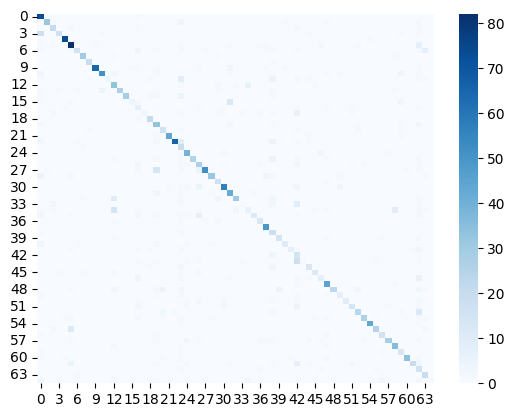

Evaluating Zero-Shot on domain : Real World
              precision    recall  f1-score   support

           0     0.7589    0.9884    0.8586        86
           1     1.0000    0.9596    0.9794        99
           2     0.7711    1.0000    0.8707        64
           3     0.9855    0.8193    0.8947        83
           4     0.9794    0.9596    0.9694        99
           5     0.8592    0.7821    0.8188        78
           6     0.9167    0.6875    0.7857        80
           7     0.7978    0.9726    0.8765        73
           8     0.8933    0.9853    0.9371        68
           9     0.9800    0.9899    0.9849        99
          10     0.9355    0.9062    0.9206        96
          11     0.8333    0.2308    0.3614        65
          12     0.5114    0.7031    0.5921        64
          13     0.9649    0.7237    0.8271        76
          14     1.0000    0.9863    0.9931        73
          15     1.0000    0.4839    0.6522        62
          16     0.6667    0.7059    

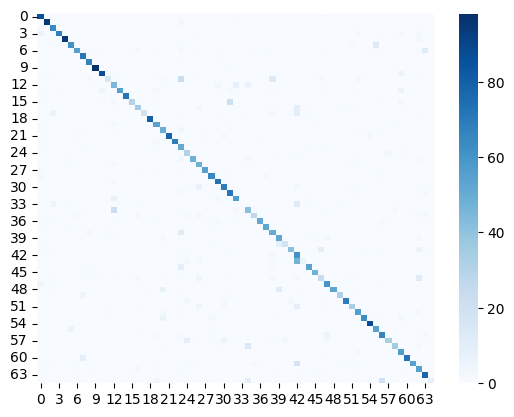

Evaluating Zero-Shot on domain : Product
              precision    recall  f1-score   support

           0     0.7358    0.9873    0.8432        79
           1     0.9588    0.9394    0.9490        99
           2     0.6522    0.9677    0.7792        62
           3     0.8936    0.9767    0.9333        43
           4     0.9565    1.0000    0.9778        44
           5     0.8868    0.7581    0.8174        62
           6     0.9189    0.7234    0.8095        47
           7     0.7788    1.0000    0.8757        81
           8     0.9500    0.9383    0.9441        81
           9     0.9811    0.9286    0.9541        56
          10     0.9540    0.8384    0.8925        99
          11     1.0000    0.1538    0.2667        65
          12     0.9178    0.6979    0.7929        96
          13     0.9643    0.9205    0.9419        88
          14     1.0000    0.8533    0.9209        75
          15     0.9836    0.7229    0.8333        83
          16     0.7303    0.9701    0.8

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


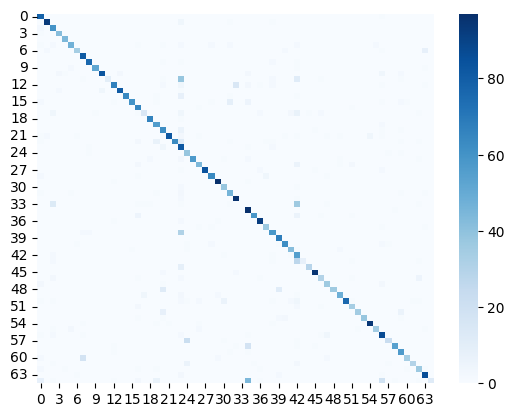

Evaluating Zero-Shot on domain : Clipart
              precision    recall  f1-score   support

           0     0.3140    0.9000    0.4655        60
           1     1.0000    0.6964    0.8211        56
           2     0.5059    0.6719    0.5772        64
           3     0.8833    0.5408    0.6709        98
           4     0.9684    0.9293    0.9485        99
           5     0.7059    0.6061    0.6522        99
           6     0.7447    0.4795    0.5833        73
           7     0.3309    0.9783    0.4945        46
           8     0.9467    0.9103    0.9281        78
           9     0.9773    0.4343    0.6014        99
          10     0.9750    0.7879    0.8715        99
          11     0.0000    0.0000    0.0000        40
          12     0.2984    0.5758    0.3931        99
          13     0.8611    0.4844    0.6200        64
          14     1.0000    0.5476    0.7077        42
          15     0.5000    0.0244    0.0465        41
          16     0.2308    0.6250    0.3

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


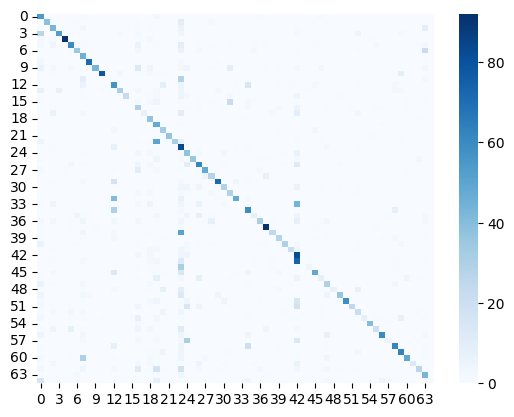

In [44]:
prompts = get_text_features(classes)
for domain, cache in cache_store.items():
    print(f"Evaluating Zero-Shot on domain : {domain}")
    eval_cache(cache, prompts)

Evaluating Zero-Shot on domain : Art (with modified prompts)
              precision    recall  f1-score   support

           0     0.7396    0.9595    0.8353        74
           1     0.9677    0.7317    0.8333        41
           2     0.5714    0.7407    0.6452        27
           3     0.7273    0.8000    0.7619        40
           4     0.9487    0.9867    0.9673        75
           5     0.7619    0.8081    0.7843        99
           6     0.8000    0.1000    0.1778        40
           7     0.9677    0.9091    0.9375        33
           8     0.4348    1.0000    0.6061        20
           9     0.9710    0.8816    0.9241        76
          10     0.7195    0.8551    0.7815        69
          11     1.0000    0.0800    0.1481        25
          12     0.4098    0.5682    0.4762        44
          13     1.0000    0.1500    0.2609        40
          14     1.0000    0.6750    0.8060        40
          15     1.0000    0.0870    0.1600        23
          16     0.1

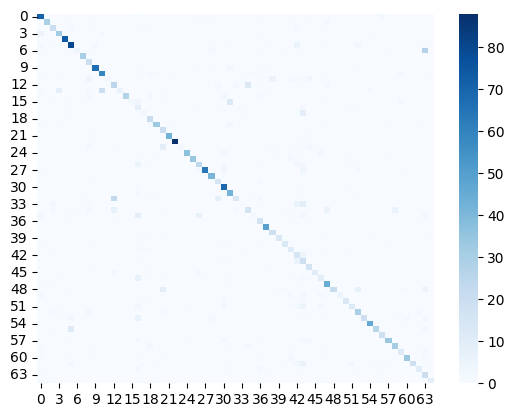

Evaluating Zero-Shot on domain : Real World (with modified prompts)
              precision    recall  f1-score   support

           0     0.8673    0.9884    0.9239        86
           1     1.0000    0.9394    0.9688        99
           2     0.7711    1.0000    0.8707        64
           3     0.8526    0.9759    0.9101        83
           4     0.9706    1.0000    0.9851        99
           5     0.7586    0.8462    0.8000        78
           6     0.8889    0.6000    0.7164        80
           7     0.9467    0.9726    0.9595        73
           8     0.7083    1.0000    0.8293        68
           9     1.0000    0.9899    0.9949        99
          10     0.8624    0.9792    0.9171        96
          11     0.8667    0.2000    0.3250        65
          12     0.4412    0.7031    0.5422        64
          13     0.9722    0.4605    0.6250        76
          14     1.0000    0.9863    0.9931        73
          15     0.9231    0.3871    0.5455        62
          16 

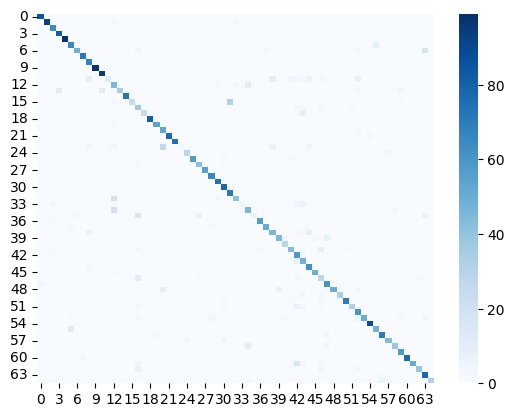

Evaluating Zero-Shot on domain : Product (with modified prompts)
              precision    recall  f1-score   support

           0     0.9070    0.9873    0.9455        79
           1     0.9891    0.9192    0.9529        99
           2     0.6186    0.9677    0.7547        62
           3     0.8269    1.0000    0.9053        43
           4     0.9565    1.0000    0.9778        44
           5     0.7460    0.7581    0.7520        62
           6     0.7667    0.4894    0.5974        47
           7     0.8901    1.0000    0.9419        81
           8     0.7670    0.9753    0.8587        81
           9     1.0000    0.9286    0.9630        56
          10     0.8762    0.9293    0.9020        99
          11     0.6250    0.1538    0.2469        65
          12     0.4545    0.8333    0.5882        96
          13     1.0000    0.7955    0.8861        88
          14     1.0000    0.8533    0.9209        75
          15     0.9808    0.6145    0.7556        83
          16    

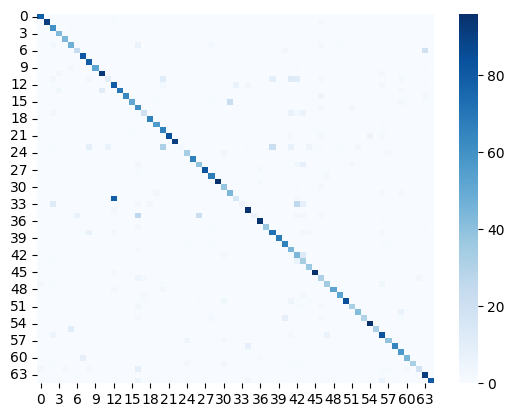

Evaluating Zero-Shot on domain : Clipart (with modified prompts)
              precision    recall  f1-score   support

           0     0.4167    0.9167    0.5729        60
           1     1.0000    0.6429    0.7826        56
           2     0.5873    0.5781    0.5827        64
           3     0.8611    0.6327    0.7294        98
           4     0.9890    0.9091    0.9474        99
           5     0.7500    0.5152    0.6108        99
           6     0.7500    0.0822    0.1481        73
           7     0.6613    0.8913    0.7593        46
           8     0.4326    0.9872    0.6016        78
           9     0.9815    0.5354    0.6928        99
          10     0.8830    0.8384    0.8601        99
          11     0.0000    0.0000    0.0000        40
          12     0.2374    0.6162    0.3427        99
          13     1.0000    0.2969    0.4578        64
          14     1.0000    0.4286    0.6000        42
          15     1.0000    0.0244    0.0476        41
          16    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


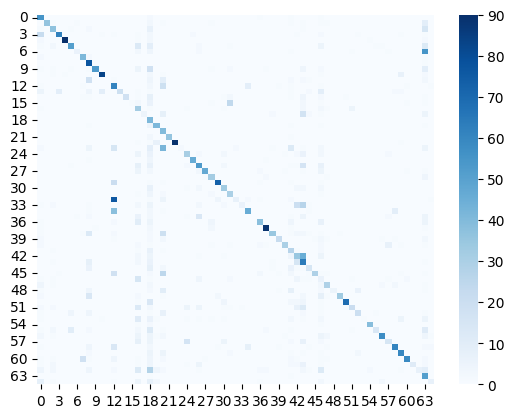

In [46]:
prompts = get_text_features(["look at that "+ cls for cls in classes])
for domain, cache in cache_store.items():
    print(f"Evaluating Zero-Shot on domain : {domain} (with modified prompts)")
    eval_cache(cache, prompts)

Evaluating Zero-Shot on domain : Art (with domain-specific prompts)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     1.0000    0.1622    0.2791        74
           1     0.9706    0.8049    0.8800        41
           2     0.8261    0.7037    0.7600        27
           3     0.9524    0.5000    0.6557        40
           4     0.9600    0.9600    0.9600        75
           5     0.5112    0.9192    0.6570        99
           6     0.7600    0.4750    0.5846        40
           7     0.7750    0.9394    0.8493        33
           8     0.1333    1.0000    0.2353        20
           9     0.7423    0.9474    0.8324        76
          10     0.8684    0.4783    0.6168        69
          11     0.5833    0.2800    0.3784        25
          12     0.1117    0.9091    0.1990        44
          13     0.8286    0.7250    0.7733        40
          14     0.9333    0.7000    0.8000        40
          15     0.5000    0.1304    0.2069        23
          16     0.5556    0.3333    0.4167        15
          17     1.0000    

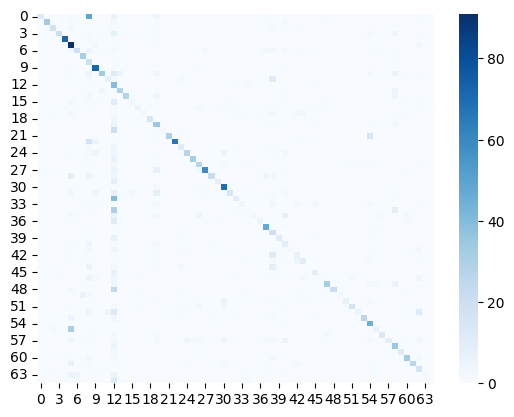

Evaluating Zero-Shot on domain : Real World (with domain-specific prompts)
              precision    recall  f1-score   support

           0     0.8947    0.9884    0.9392        86
           1     0.9900    1.0000    0.9950        99
           2     0.9365    0.9219    0.9291        64
           3     0.9494    0.9036    0.9259        83
           4     0.9800    0.9899    0.9849        99
           5     0.7184    0.9487    0.8177        78
           6     0.7714    0.6750    0.7200        80
           7     0.9851    0.9041    0.9429        73
           8     0.8718    1.0000    0.9315        68
           9     1.0000    1.0000    1.0000        99
          10     0.9579    0.9479    0.9529        96
          11     0.6531    0.4923    0.5614        65
          12     0.3077    0.7500    0.4364        64
          13     0.9545    0.8289    0.8873        76
          14     1.0000    1.0000    1.0000        73
          15     0.9032    0.4516    0.6022        62
      

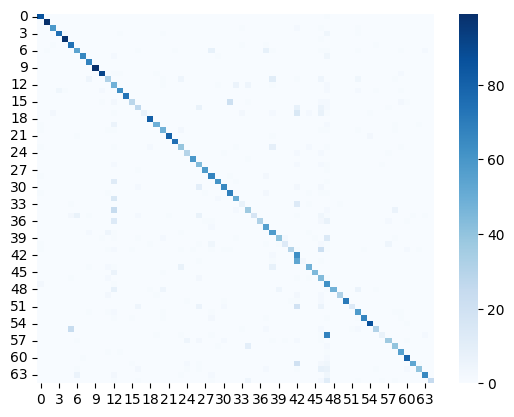

Evaluating Zero-Shot on domain : Product (with domain-specific prompts)
              precision    recall  f1-score   support

           0     1.0000    0.4810    0.6496        79
           1     0.9697    0.9697    0.9697        99
           2     0.9730    0.5806    0.7273        62
           3     0.9149    1.0000    0.9556        43
           4     0.8000    1.0000    0.8889        44
           5     0.9455    0.8387    0.8889        62
           6     0.6462    0.8936    0.7500        47
           7     0.9877    0.9877    0.9877        81
           8     0.9615    0.9259    0.9434        81
           9     1.0000    0.9286    0.9630        56
          10     0.8889    0.8081    0.8466        99
          11     1.0000    0.1538    0.2667        65
          12     0.5321    0.8646    0.6587        96
          13     0.9111    0.9318    0.9213        88
          14     0.9342    0.9467    0.9404        75
          15     1.0000    0.1084    0.1957        83
         

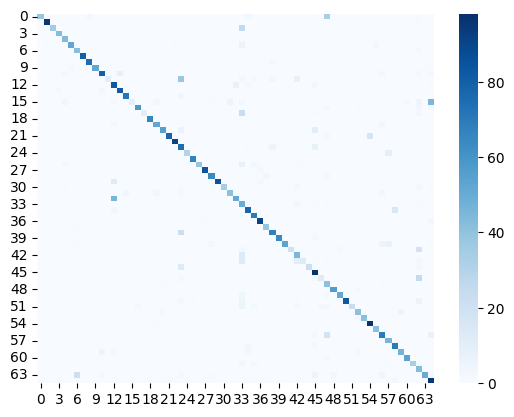

Evaluating Zero-Shot on domain : Clipart (with domain-specific prompts)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.9792    0.7833    0.8704        60
           1     0.9583    0.8214    0.8846        56
           2     0.7674    0.5156    0.6168        64
           3     0.8265    0.8265    0.8265        98
           4     1.0000    0.9293    0.9634        99
           5     0.5946    0.6667    0.6286        99
           6     0.7907    0.4658    0.5862        73
           7     0.7213    0.9565    0.8224        46
           8     0.8621    0.9615    0.9091        78
           9     0.9559    0.6566    0.7784        99
          10     0.9714    0.6869    0.8047        99
          11     0.8000    0.1000    0.1778        40
          12     0.2555    0.3535    0.2966        99
          13     0.9091    0.4688    0.6186        64
          14     1.0000    0.6667    0.8000        42
          15     1.0000    0.0244    0.0476        41
          16     0.6111    0.6875    0.6471        48
          17     0.0000    

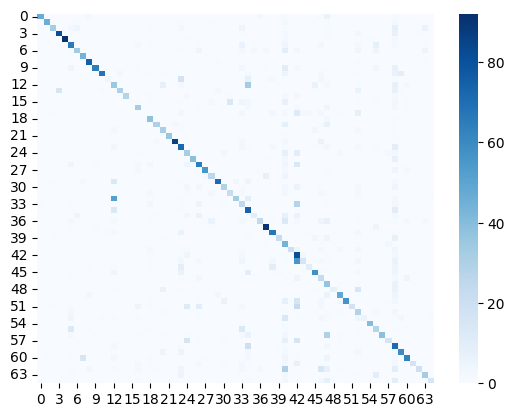

In [49]:
for domain, cache in cache_store.items():
    print(f"Evaluating Zero-Shot on domain : {domain} (with domain-specific prompts)")
    prompts = get_text_features([f"{domain} photo of "+ cls for cls in classes])
    eval_cache(cache, prompts)

### Evaluating CLIP accuracy on Image Features

In [ ]:
print("hello")

In [ ]:
from sklearn.linear_model import LogisticRegression

torch.manual_seed(100)

classifiers = {}
for domain in domains:
    print(f"Probing on domain : {domain}")
    features, labels = cache_store[domain]
    classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
    classifier.fit(features, labels)
    classifiers[domain] = classifier 
  
   

Probing on domain : Art


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s finished


Probing on domain : Real World


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s finished


Probing on domain : Product


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.7s finished


Probing on domain : Clipart


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s finished


In [75]:
domains

['Art', 'Real World', 'Product', 'Clipart']

Product -> Real World
              precision    recall  f1-score   support

           0     0.9140    0.9884    0.9497        86
           1     0.9897    0.9697    0.9796        99
           2     0.9815    0.8281    0.8983        64
           3     0.9589    0.8434    0.8974        83
           4     0.9895    0.9495    0.9691        99
           5     0.7460    0.6026    0.6667        78
           6     0.7750    0.7750    0.7750        80
           7     0.8987    0.9726    0.9342        73
           8     0.9067    1.0000    0.9510        68
           9     0.9286    0.9192    0.9239        99
          10     0.8364    0.9583    0.8932        96
          11     0.6000    0.3231    0.4200        65
          12     0.3171    0.6094    0.4171        64
          13     0.9153    0.7105    0.8000        76
          14     0.7742    0.9863    0.8675        73
          15     0.6941    0.9516    0.8027        62
          16     0.9697    0.6275    0.7619        51
     

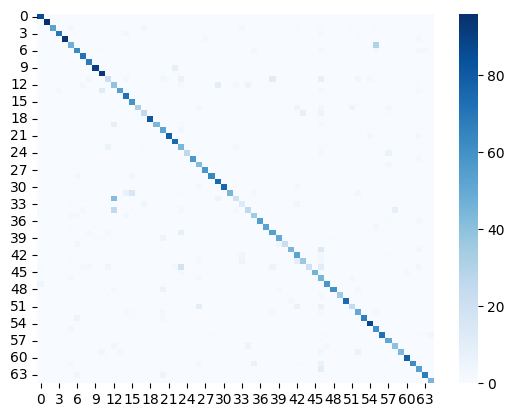

Art -> Clipart
              precision    recall  f1-score   support

           0     0.9286    0.8667    0.8966        60
           1     0.9730    0.6429    0.7742        56
           2     0.6066    0.5781    0.5920        64
           3     0.9508    0.5918    0.7296        98
           4     0.9293    0.9293    0.9293        99
           5     0.9688    0.3131    0.4733        99
           6     0.4113    0.6986    0.5178        73
           7     0.5641    0.9565    0.7097        46
           8     1.0000    0.8590    0.9241        78
           9     0.9429    0.6667    0.7811        99
          10     0.9853    0.6768    0.8024        99
          11     0.1976    0.8250    0.3188        40
          12     0.3760    0.4747    0.4196        99
          13     0.7800    0.6094    0.6842        64
          14     0.7692    0.7143    0.7407        42
          15     0.2500    0.3659    0.2970        41
          16     0.5294    0.5625    0.5455        48
          17

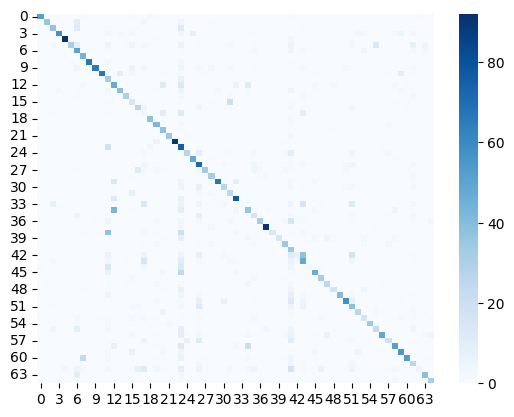

Product -> Art
              precision    recall  f1-score   support

           0     0.9167    0.8919    0.9041        74
           1     0.9667    0.7073    0.8169        41
           2     1.0000    0.4815    0.6500        27
           3     0.8929    0.6250    0.7353        40
           4     1.0000    0.8400    0.9130        75
           5     0.5789    0.5556    0.5670        99
           6     0.5714    0.3000    0.3934        40
           7     0.9062    0.8788    0.8923        33
           8     0.6452    1.0000    0.7843        20
           9     0.9429    0.8684    0.9041        76
          10     0.6463    0.7681    0.7020        69
          11     0.6250    0.4000    0.4878        25
          12     0.2195    0.2045    0.2118        44
          13     0.8889    0.4000    0.5517        40
          14     0.5185    0.7000    0.5957        40
          15     0.2449    0.5217    0.3333        23
          16     0.7143    0.3333    0.4545        15
          17

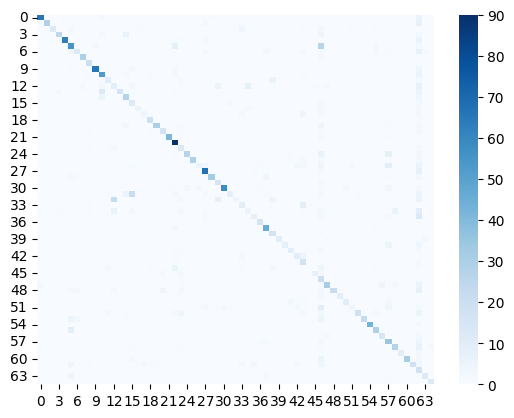

Art -> Real World
              precision    recall  f1-score   support

           0     0.9767    0.9767    0.9767        86
           1     0.9406    0.9596    0.9500        99
           2     0.7381    0.9688    0.8378        64
           3     0.7426    0.9036    0.8152        83
           4     0.9252    1.0000    0.9612        99
           5     0.8704    0.6026    0.7121        78
           6     0.6900    0.8625    0.7667        80
           7     0.8182    0.9863    0.8944        73
           8     0.9714    1.0000    0.9855        68
           9     0.9700    0.9798    0.9749        99
          10     0.9175    0.9271    0.9223        96
          11     0.6122    0.4615    0.5263        65
          12     0.5455    0.6562    0.5957        64
          13     0.9385    0.8026    0.8652        76
          14     0.9524    0.5479    0.6957        73
          15     0.7941    0.4355    0.5625        62
          16     0.8974    0.6863    0.7778        51
         

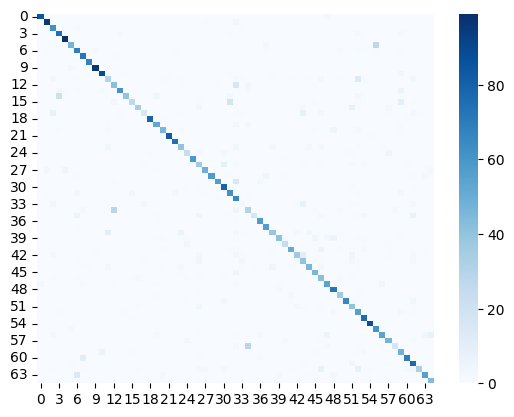

Real World -> Clipart
              precision    recall  f1-score   support

           0     0.9434    0.8333    0.8850        60
           1     1.0000    0.7321    0.8454        56
           2     0.9286    0.4062    0.5652        64
           3     0.9701    0.6633    0.7879        98
           4     0.9785    0.9192    0.9479        99
           5     0.8421    0.4848    0.6154        99
           6     0.5867    0.6027    0.5946        73
           7     0.7167    0.9348    0.8113        46
           8     0.9437    0.8590    0.8993        78
           9     0.9661    0.5758    0.7215        99
          10     0.9467    0.7172    0.8161        99
          11     0.4444    0.1000    0.1633        40
          12     0.3148    0.5152    0.3908        99
          13     0.7288    0.6719    0.6992        64
          14     0.9630    0.6190    0.7536        42
          15     0.4375    0.1707    0.2456        41
          16     0.7826    0.3750    0.5070        48
     

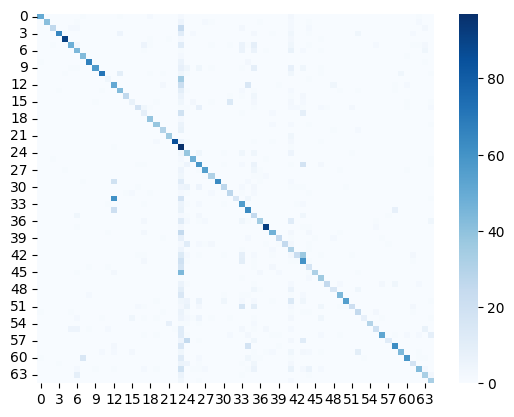

Product -> Clipart
              precision    recall  f1-score   support

           0     0.8571    0.8000    0.8276        60
           1     1.0000    0.6429    0.7826        56
           2     1.0000    0.4062    0.5778        64
           3     0.9792    0.4796    0.6438        98
           4     1.0000    0.9192    0.9579        99
           5     0.3834    0.7475    0.5068        99
           6     0.6393    0.5342    0.5821        73
           7     0.8400    0.9130    0.8750        46
           8     0.6754    0.9872    0.8021        78
           9     1.0000    0.4242    0.5957        99
          10     0.7822    0.7980    0.7900        99
          11     0.2101    0.6250    0.3145        40
          12     0.3939    0.5253    0.4502        99
          13     0.8857    0.4844    0.6263        64
          14     0.7500    0.5714    0.6486        42
          15     0.3111    0.3415    0.3256        41
          16     0.9167    0.4583    0.6111        48
        

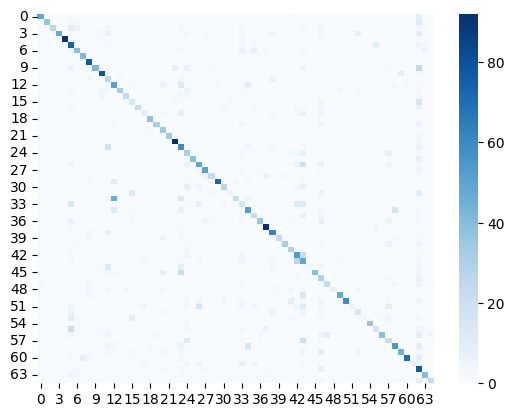

In [79]:
pairs = [
    # Low-shift
    ("Product", "Real World"),
    ("Art", "Clipart"),

    # Medium-shift
    ("Product", "Art"),
    ("Art", "Real World"),

    # High-shift
    ("Real World", "Clipart"),
    ("Product", "Clipart")
]

for source, target in pairs:
    print(f"{source} -> {target}")
    classifier = classifiers[source]
    target_features, target_labels = cache_store[target]
    predictions = classifier.predict(target_features)
  
    stats(torch.Tensor(predictions), target_labels)
    


### Co-op  and Co-Co-op

### Exploring the Modality Gap


In this section, we explore the modality gap in multi-modal embedding space of clip. We use 5000 examples from and umap for dimensionality reduction. 


In [56]:
import umap

epsilon = 0.01
def reduce_features(features:torch.tensor):
    clone = features.clone().detach()
    reduced = torch.tensor(umap.UMAP(n_neighbors=30, n_components=2).fit_transform(clone))
    return reduced

def visualize_map(image_features: torch.tensor, text_features: torch.tensor):

    X, Y  = image_features[:, 0], image_features[:, 1]
    plt.scatter(X, Y, c="r",label="Image features",
        alpha=0.6, edgecolors='k', marker="o")
    
    X, Y  = text_features[:, 0], text_features[:, 1]
    plt.scatter(X, Y, c="b",  label="Text features",
        alpha=0.6,  edgecolors='k', marker="^")

    plt.title("CLIP Feature Space (2D)")
    plt.xlabel("Feature dimension 1")
    plt.ylabel("Feature dimension 2")
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.show()

def plot_embedding_space(image_features: torch.tensor, text_features: torch.tensor):
    N = len(image_features)
    embeddings = torch.cat([image_features, text_features], dim=0)
    reduced = reduce_features(embeddings)
    visualize_map(reduced[:N], reduced[N:])



2025-09-08 09:34:38.157538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757324078.468790      72 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757324078.555538      72 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [57]:
class_embeddings = get_text_features(classes)

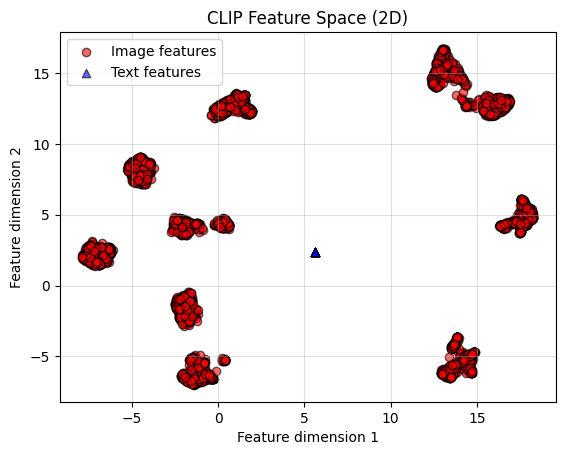

In [58]:
plot_embedding_space(features, class_embeddings)

As can be see above, the modality gap between image and text features is larger than one would have expected. Moreover all label embeddings are concentrated in a single region. Below we test text embeddings extracted from pinterest, similar to the data the model was trained on. We also try to visualize the multi-model embedding space after normalizing features.

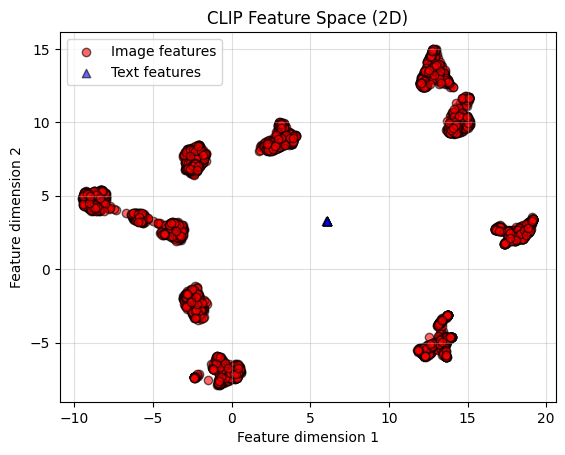

In [60]:
combined = torch.concat([features, class_embeddings], dim=0)
mean = combined.mean()
std = combined.std()
normalized = (combined-mean)/std
plot_embedding_space(normalized[:len(features)], normalized[len(features):])


In [311]:
import requests 
from bs4 import BeautifulSoup

url = 'https://www.pinterest.com/ideas/'
resp = requests.get(url)
soup = BeautifulSoup(resp.content, features="html.parser")

tags = soup.find_all('a')
captions = [tag.text for tag in tags]

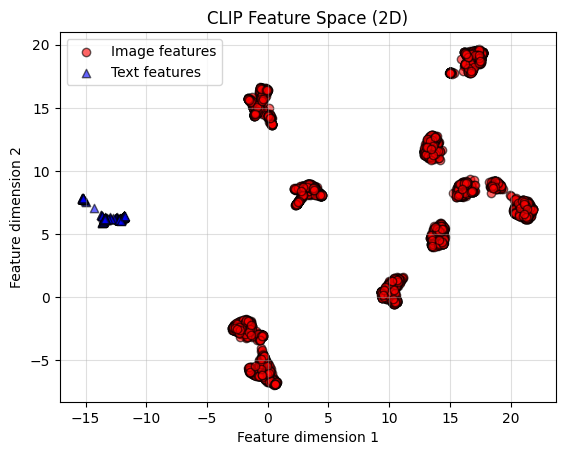

In [312]:
text_features = get_text_features(captions)
plot_embedding_space(features, text_features)

### Bridging the Modality Gap

In this section we try to align that modalities in multi-modal embedding space using the orthogonal procrustes transform.

In [69]:
from scipy.linalg import orthogonal_procrustes

text_embeddings = torch.stack([class_embeddings[i] for i in labels.tolist()], dim=0)
R, _ = orthogonal_procrustes(features, text_embeddings)
rotated_embeddings = features@R

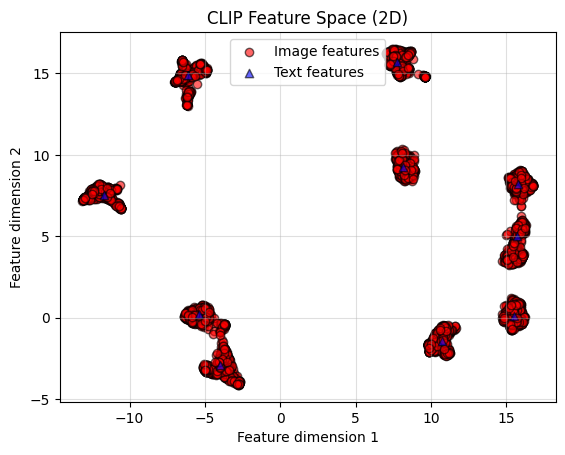

In [70]:
plot_embedding_space(rotated_embeddings, class_embeddings)

              precision    recall  f1-score   support

           0       1.00      0.80      0.89       500
           1       0.86      1.00      0.92       500
           2       1.00      0.96      0.98       500
           3       1.00      0.74      0.85       500
           4       1.00      0.77      0.87       500
           5       0.74      1.00      0.85       500
           6       0.96      0.99      0.97       500
           7       0.97      0.92      0.94       500
           8       0.81      1.00      0.90       500
           9       0.96      0.99      0.97       500

    accuracy                           0.92      5000
   macro avg       0.93      0.92      0.91      5000
weighted avg       0.93      0.92      0.91      5000



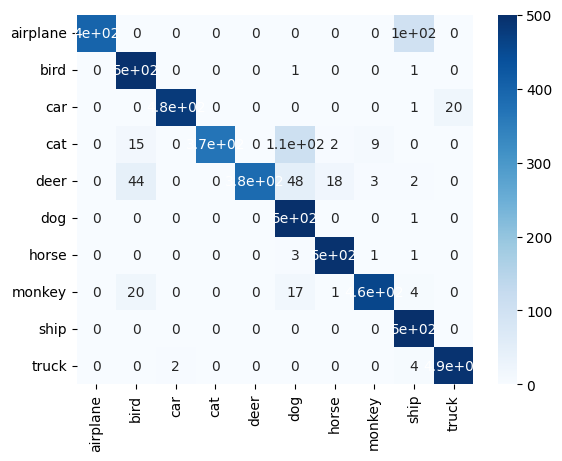

In [71]:
eval(rotated_embeddings, class_embeddings, labels)